# Test Our DAC Controller(s)
The point of this sanity check is to ensure that our disturbance-feedback controllers work well. In particular, we need to make sure that our zero order optimization is stable.

### some notes
- ADAM is the best optimizer for us
- the REINFORCE updates to K work (i think)
- EvanBPC and RBPC are about the same on LDS, but EvanBPC generally is more robust (cause ADAM)

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS

from extravaganza.controllers import EvanBPC
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.observables import FullObservation, PartialObservation, TimeDelayedObservation
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC
from extravaganza.rescalers import ADAM, FIXED_RESCALE
from extravaganza.utils import ylim, render
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpqvsondh2
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpqvsondh2/_remote_module_non_scriptable.py


In [2]:
disturbance_type = 'sinusoidal'

# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 2000  # total timesteps
reset_condition = lambda t: False  # how often to reset the system
use_multiprocessing = False
render_every = None

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 2  # control dim
ds = 4  # state dim

cost_fn = 'quad'

make_system = lambda : LDS(ds, du, disturbance_type, cost_fn, seed=SYSTEM_SEED)
observable = FullObservation(state_dim=ds)

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 5  # controller memory length (# of w's to use on inference)
m_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.9, 0.999), use_bias_correction=True)
m0_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.9, 0.999), use_bias_correction=True)
k_update_rescaler = lambda : ADAM(alpha=0.00, betas=(0.9, 0.999), use_bias_correction=True)

evan_bpc_args = {
    'h': h,  
    'method': 'REINFORCE',
    'initial_scales': (0, 0.01, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'bounds': None,
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_tanh': False,
    'use_stabilizing_K': True,
    'seed': CONTROLLER_SEED
}

make_controllers = {
    'LQR': lambda sys: LQR(A=sys.A, B=sys.B, seed=CONTROLLER_SEED),
#     'HINF': lambda sys: HINF(A=sys.A, B=sys.B, T=T, seed=CONTROLLER_SEED),
    'GPC': lambda sys: GPC(A=sys.A, B=sys.B, H=h, lr_scale=0.01, decay=True, seed=CONTROLLER_SEED),
#     'BPC': lambda sys: BPC(A=sys.A, B=sys.B, H=h, lr_scale=0.01, decay=True, delta=0.001, seed=CONTROLLER_SEED),
#     'RBPC': lambda sys: RBPC(A=sys.A, B=sys.B, M=h, lr=0.02, delta=0.001, noise_sd=0.05, seed=CONTROLLER_SEED),
    'Evan BPC': lambda sys: EvanBPC(A=sys.A, B=sys.B, **evan_bpc_args)
}
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'observable': observable,
    'num_trials': num_trials,
    'T': T,
    'reset_condition': reset_condition,
    'reset_seed': None,
    'use_multiprocessing': use_multiprocessing,
    'render_every': render_every,
}

experiment = Experiment('')
experiment(**experiment_args)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing LQR
100%|█████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 818.20it/s, control=[ 0.03196046 -0.06657434], cost=2.49]
INFO: 
INFO: (EXPERIMENT): testing GPC
100%|█

defaultdict(list,
            {'LQR': <extravaganza.stats.Stats at 0x28b5b4eb0>,
             'GPC': <extravaganza.stats.Stats at 0x2a32f1d50>,
             'Evan BPC': <extravaganza.stats.Stats at 0x2a6cb41f0>})

<Figure size 640x480 with 0 Axes>

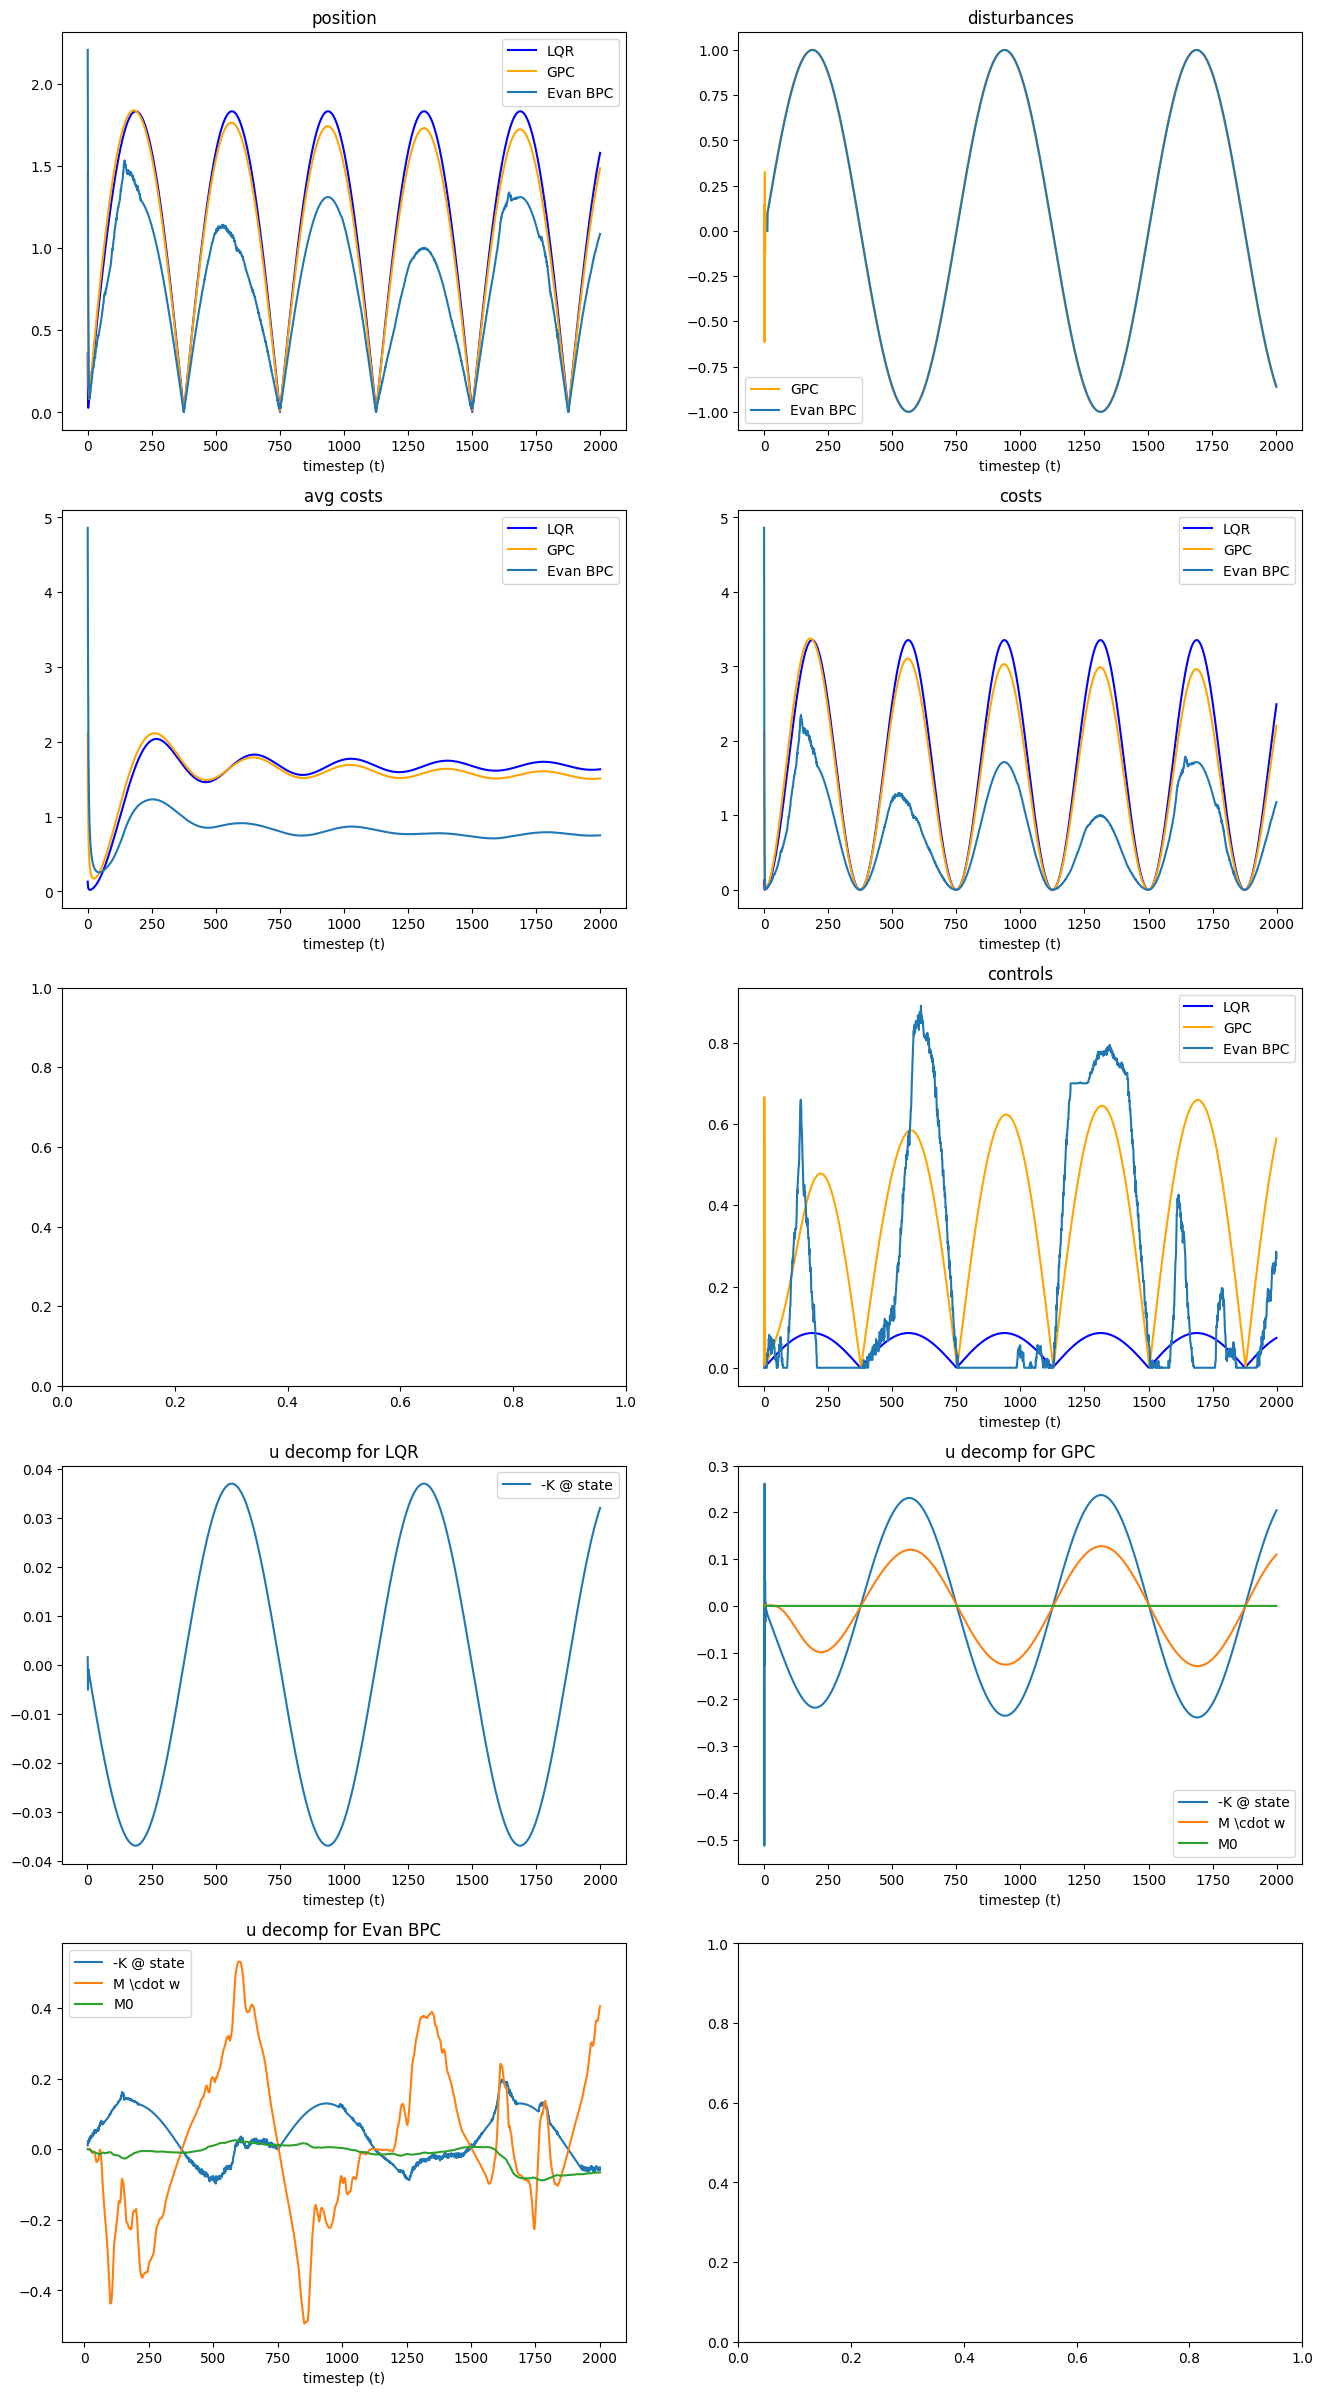

In [3]:
def plot_lds(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 3
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'true states', label=method, plot_norm=True)
        stats.plot(ax[2, 1], 'controls', label=method, plot_norm=True)
        stats.plot(ax[1, 0], 'costs', label=method, plot_cummean=True)
        stats.plot(ax[1, 1], 'costs', label=method)
    
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method, plot_idx=0)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('avg costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend()
    
    _ax = ax[2, 1]; _ax.set_title('controls'); _ax.legend()
    pass
plot_lds(experiment)